# Predict sales from 2012 - 2013 using :
    - 2010 - 2012 sales
    - 2010 - 2013 feature data
    - stores dataset
    - finally, insert (test.csv 2012-2013 + features.csv from 2012-2013) to model and predict sales

    
    - source https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview

# Obtain

In [449]:
# load necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# ori walmart - macos (train.csv = sales data-set.csv)
df_features = pd.read_csv("/Users/dwihadyan/Downloads/theleadio/ds-exploration/p2/walmart-recruiting-store-sales-forecasting/features.csv", parse_dates=['Date'])  # parse_date to ensure Date in 'datetime64' format
df_sales = pd.read_csv("/Users/dwihadyan/Downloads/theleadio/ds-exploration/p2/walmart-recruiting-store-sales-forecasting/train.csv",  parse_dates=['Date'])
df_sales_answer = pd.read_csv("/Users/dwihadyan/Downloads/theleadio/ds-exploration/p2/walmart-recruiting-store-sales-forecasting/test.csv",  parse_dates=['Date'])
df_stores = pd.read_csv("/Users/dwihadyan/Downloads/theleadio/ds-exploration/p2/walmart-recruiting-store-sales-forecasting/stores.csv")


# Scrub

- combine all 3 datasets into one
- then separate into train inclusive(2010-02-05 until 2012-10-26) and test (2012-11-02 until 2013-07-26)

In [450]:
# why lengthRow feature < sales ? 
# because in df_sales 'Dept'. 1 store = multiple dept (up to 51 unique dept each), and each dept have their unique weekly_sales. proven with this code, and can see that in df_sales have 1 store & many dept

df_features[(df_features['Store'] == 1)]
df_sales[(df_sales['Store'] == 1)]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
10239,1,99,2012-08-31,20.06,False
10240,1,99,2012-09-07,0.05,True
10241,1,99,2012-09-14,0.03,False
10242,1,99,2012-10-05,635.00,False


In [451]:
# combine all 4 training dataset into one. from largest to smallest

# merge two sales into one for now
sales_answer = pd.merge(df_sales ,df_sales_answer, how='outer', on=['Store', 'Dept', 'Date', 'IsHoliday'])

# merge features & stores on 'store' key
sales_feat = pd.merge(sales_answer ,df_features, how='outer', on=['Store', 'Date', 'IsHoliday'])

# merge sales_feat & sales on 'Store' and 'Date' key
df_all = pd.merge(sales_feat, df_stores, how='outer', on='Store')

In [452]:
# commented out, as this competition requirements is they want set IsHoliday conversion in their own error measurement (WMAE).
# see "Model" section below

# # convert is_holiday to true : 5, false : 1. requirements were to set 5 for holiday, 1 as nope(this true & false is NOT string btw. its boolean)
# df['IsHoliday'] = df['IsHoliday'].map({False : 1, True : 5})



In [453]:
def multipledummies(df, non_numerical_columns):
    ''' Input the whole dataframe & name of non-numerical columns, output is clean dataframe that all is in numerical format'''

    for i in non_numerical_columns:

        # convert to numerical using get_dummies
        one_hot = pd.get_dummies(df[i], prefix=i)

        # append new numerical column to main df
        df = df.join(one_hot)

        # drop that non-numerical column
        df.drop(i, axis = 1, inplace=True)

    return df




In [454]:
# convert Date to 'Day, Week, Month' to make it numerical
df_all['Day'] = df_all.Date.dt.day
df_all['Week'] = df_all.Date.dt.week 
df_all['Year'] = df_all.Date.dt.year


/var/folders/29/_r682w3n2m95fqd9bv6_hk300000gn/T/ipykernel_3135/2839496647.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_all['Week'] = df_all.Date.dt.week


In [455]:
# convert Type columns to numerical using multipledummies
df_all = multipledummies(df_all, ['Type'])
df_all.sample(3)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Size,Day,Week,Year,Type_A,Type_B,Type_C
519440,44,18,2011-10-07,366.35,False,60.62,3.592,NaN,NaN,NaN,...,NaN,129.693800,6.078,39910,7,40,2011,0,0,1
125866,11,12,2010-06-18,4853.61,False,84.13,2.637,NaN,NaN,NaN,...,NaN,214.785826,7.343,207499,18,24,2010,1,0,0
249965,20,60,2013-03-08,NaN,False,31.28,3.860,28108.16,446.02,136.05,...,3644.31,217.293249,7.439,203742,8,10,2013,1,0,0


In [456]:
# separate df into data inclusive(2010-02-05 until 2012-10-26) and answer (2012-11-02 until 2013-07-26)

data_range = (df_all['Date'] >= '2010-02-05') & (df_all['Date'] <= '2012-10-26')
answer_range = (df_all['Date'] >= '2012-11-02') & (df_all['Date'] <= '2013-07-26')


df = df_all.loc[data_range]
df_answer = df_all.loc[answer_range]


# drop date column now since its been segregated properly already
df.drop(['Date'], axis=1, inplace=True)
df_answer.drop(['Date'], axis=1, inplace=True)

/Users/dwihadyan/opt/anaconda3/envs/quantra38/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [457]:
# ensure all columns in df is in integer format before done with "scrub" section
df.info()
df_answer.info()

# for multiple null, we check in heatmap first, if weak correlation (between 0.1 & -0.1) with weekly_sales, we drop those column. else we use IterativeImputer() package

# IsHoliday stays boolean object for now. converted in 'Model' section WMAE function

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 534007
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  object 
 4   Temperature   421570 non-null  float64
 5   Fuel_Price    421570 non-null  float64
 6   MarkDown1     150681 non-null  float64
 7   MarkDown2     111248 non-null  float64
 8   MarkDown3     137091 non-null  float64
 9   MarkDown4     134967 non-null  float64
 10  MarkDown5     151432 non-null  float64
 11  CPI           421570 non-null  float64
 12  Unemployment  421570 non-null  float64
 13  Size          421570 non-null  int64  
 14  Day           421570 non-null  int64  
 15  Week          421570 non-null  int64  
 16  Year          421570 non-null  int64  
 17  Type_A        421570 non-null  uint8  
 18  Type

### fillup all NaN using :
    - https://www.kaggle.com/shubhamsinghgharsele/retail-data-analysis#Work-In-Progress
        - markdown using IterativeImputer() package (thats just injecting data that never existed, so dont do that). 
        - cpi & unemployment using mean()


    - https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting/notebook
        - drop markdown because it has weak correlation with target variable. (kinda make sense). 
        - drop cpi, unemployment, temperature, fuel_price because has weak correlation (between 0.1 & -0.1) with target variable (which is weekly_sales)





# Explore

- heatmap. drop if corr with targetVariable is between 0.1 & -0.1 

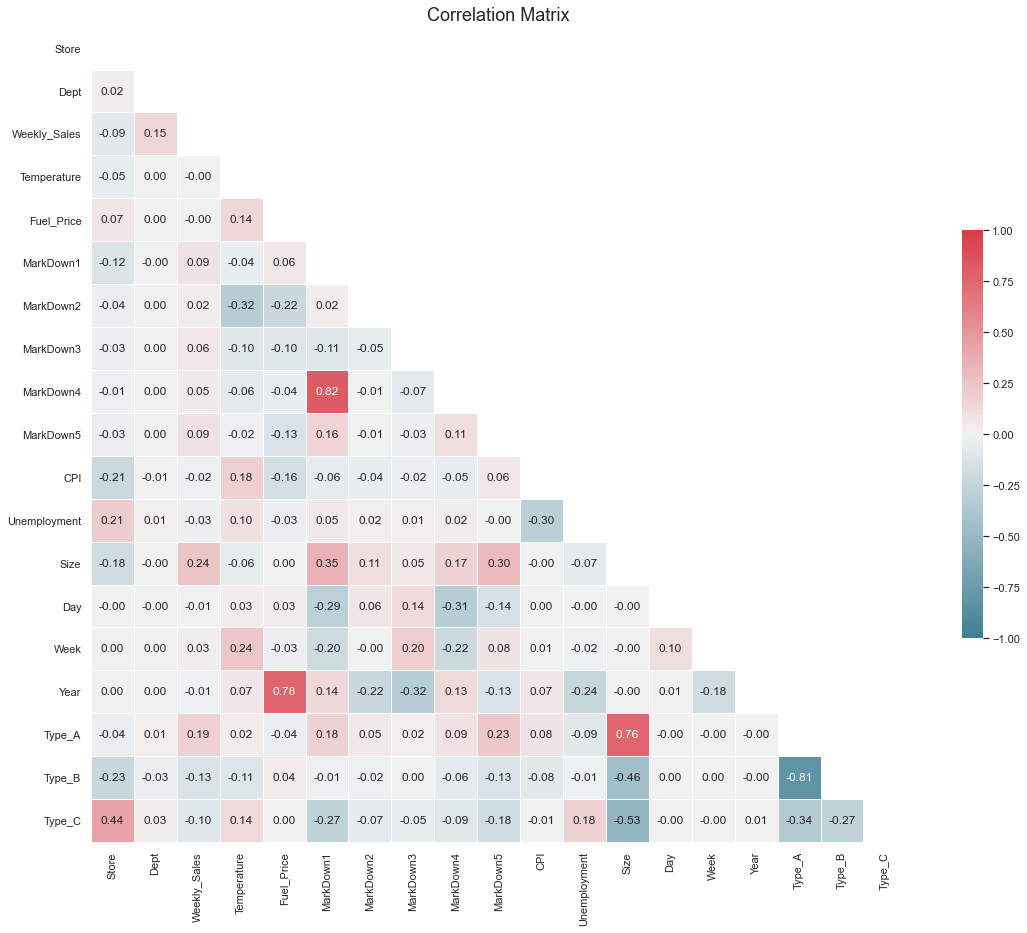

In [458]:
# sns.set(rc={'figure.figsize' : (20,18)})
# corr_matrix = df.corr()
# sns.heatmap(corr_matrix, annot = True, fmt = ".2f")

sns.set(style="white")

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

plt.show()

In [459]:
# drop CPI, Unemployment & all markdowns1-5, as it is : weak correlation to weekly_sales AND too much Null data
df.drop(['CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)
df_answer.drop(['CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)

# Model
    - Since competition error measurement is WMAE (given in competition, and not the usual RMSE from GridSearchCV), we cant use GridSearchCV or RandomSearchCV to fine-tune our model
    - Hence we will be using RandomForest with 3 laters to fine-tune
        - 1st layer : call random_forest, get best [n_estimator, max_depth]
        - 2nd layer : parameter tuning, get best [max_features] with result from 1st layer
        - 3rd layer : cross validation, get best [min_samples_split, min_samples_leaf] with result from 2nd later
    - once obtained best setting from these 3 layers of fine tune, we put in these best parameters inside the randomforestregressor

    - TLDR : we using randomforestregressor to get best parameters, and plug those parameters inside randomforestregressor in the end to get best result

In [460]:
# WMAE function as error measurement (lower the better)

def WMAE(dataset, real, predicted):
    ''' Input df, real value , predicted value. Output the error value. lower the value, more accurate our model is '''

    # weight allocation on IsHoliday
    weights = dataset.IsHoliday.apply(lambda x : 5 if x else 1)

    # WMSE formula
    return np.round(np.sum(weights * abs(real - predicted)) / (np.sum(weights)), 2)

In [461]:
# 1st layer : call random_forest, get best [n_estimator, max_depth]
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [462]:
# remove this (for now) as randomforestregresor() spits out any useless feature

# 2nd layer : parameter tuning, get best [max_features] with result from 1st layer
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [463]:
# 3rd layer : cross validation, get best [min_samples_split, min_samples_leaf] with result from 2nd later
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [464]:
# prep data

X_train = df.drop(['Weekly_Sales'], axis = 1)
Y_train = df['Weekly_Sales']


In [439]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# commented as this takes 42mins

# # 1st layer
# n_estimators = [56, 58, 60]
# max_depth = [25, 27, 30] 

# random_forest(n_estimators, max_depth)

# # max_depth 27, estimator 60 has lowest WMAE (1531.9350)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1534.835
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1545.47
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1533.6225
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1533.4125
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1534.5725
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k: 

,Max_Depth,Estimators,WMAE
0,25,56,1534.8350
1,27,56,1545.4700
2,30,56,1533.6225
3,25,58,1533.4125
4,27,58,1534.5725
5,30,58,1536.6375
6,25,60,1544.1750
7,27,60,1531.9350
8,30,60,1550.4300


In [ ]:
# # 2nd layer (comment out for now, assume best is 12 (all features))

# max_features = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# random_forest_II(n_estimators=58, max_depth=27, max_features=max_features) 

In [440]:
# 3rd layer

# commented out as this takes 247mins

# min_samples_split = [2, 3, 4]
# min_samples_leaf = [1, 2, 3]

# random_forest_III(n_estimators=58, max_depth=27, max_features=12, 
#                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

# # min_samples_leaf 1, min_samples_split 4, has lowest WMAE of 1531.2575 (with max_depth 27 & estimator 58)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1557.8300000000002
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1571.5625
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1580.33
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1539.065
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_split: 3 , 

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1557.8300
1,2,2,1571.5625
2,3,2,1580.3300
3,1,3,1539.0650
4,2,3,1551.2500
5,3,3,1599.1500
6,1,4,1531.2575
7,2,4,1546.3200
8,3,4,1580.9400


In [442]:
# takes 2 mins

# run randomforest with best parameters
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=12, min_samples_split=4, min_samples_leaf=1)
RF.fit(X_train, Y_train)




RandomForestRegressor(max_depth=27, max_features=12, min_samples_split=4,
                      n_estimators=58)

In [468]:
X_test = df_answer.drop(['Weekly_Sales'], axis = 1)
predict = RF.predict(X_test)

In [470]:
len(predict)

115064

# iNterpret

- append prediction to submission file

In [471]:
submission = pd.read_csv("/Users/dwihadyan/Downloads/theleadio/ds-exploration/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv")

In [473]:
submission['Weekly_Sales'] = predict
submission

,Id,Weekly_Sales
0,1_1_2012-11-02,33631.620102
1,1_1_2012-11-09,47628.205040
2,1_1_2012-11-16,9505.199948
3,1_1_2012-11-23,39728.177599
4,1_1_2012-11-30,29315.991177
...,...,...
115059,45_98_2013-06-28,3405.253657
115060,45_98_2013-07-05,4101.855466
115061,45_98_2013-07-12,54755.392167
115062,45_98_2013-07-19,6566.540294


In [483]:
# export file to csv

submission = submission.set_index('Id')
submission.to_csv('walmart_v1.csv', sep=',')